Multilayer Perceptron 

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import math
from IPython.display import clear_output, display


plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

In [84]:
def R_square(y_pred, y):
  y_mean = np.mean(y)
  return 1 - np.sum(np.square(y - y_pred))/np.sum(np.square(y - y_mean))

In [85]:
X = np.linspace(0, 4*math.pi, 3000)
y = np.cos(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
def get_batches(data, batch_size):
  n = len(data)
  get_X = lambda z: z[0]
  get_y = lambda z: z[1]
  for i in range(0, n, batch_size):
    batch = data[i:i+batch_size]
    yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

In [87]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))

In [88]:
class MLP:
    def __init__(self, architecture, learning_rate = 0.01):
        self.learning_rate = learning_rate
        self.depth = len(architecture)-1
        # functions
        self.activation_fn = sigmoid
        self.activation_dfn = sigmoid_derivative
        self.loss_fn = mse
        self.loss_dfn = dmse
        # parameters
        self.W = self._init_weights(architecture)
        self.b = self._init_biases(architecture)
        # feedforward outputs
        self.z = [None] * (self.depth+1)
        self.a = [None] * (self.depth+1)
        # backprop gradients
        self.dW = [np.zeros_like(w) for w in self.W]
        self.db = [np.zeros_like(b) for b in self.b]
  
  
  # glorot uniform init
    def _init_weights(self, arch):
        net_in = arch[0]
        net_out = arch[-1]
        limit = np.sqrt(6. / (net_in + net_out))
        return [rng.uniform(-limit, limit + 1e-5, size=(arch[i+1], arch[i])) for i in range(self.depth)]


    def _init_biases(self, arch):
        return [rng.random((arch[i+1],1))*2-1 for i in range(self.depth)]


    def _feedforward(self, X):
        self.a[0] = X.reshape(1, X.shape[0])
        # compute hidden and output layers
        for i in range(self.depth):
            self.z[i+1] = np.matmul(self.W[i], self.a[i]) + self.b[i]
            if i != self.depth-1:
                self.a[i+1] = self.activation_fn(self.z[i+1])
            else:
                self.a[-1] = self.z[-1]


    def _compute_loss(self, X, y):
        y_pred = self.predict(X).reshape(y.shape)
        return self.loss_fn(y_pred, y)


    def _backprop(self, y, batch_size=32):
        delta = self.loss_dfn(self.a[-1], y)
        for i in range(self.depth-1, 0, -1):
            if i != self.depth-1:
                delta = self.activation_dfn(self.z[i+1]) * np.matmul(self.W[i+1].T, delta)
            self.dW[i] = np.matmul(delta, self.a[i].T)
            self.db[i] = np.sum(delta, axis=1, keepdims=True)

  # simple sgd
  # def _update_params(self, lr=1e-2):
  #   for i in range(self.depth):
  #     self.W[i] -= lr*self.dW[i]
  #     self.b[i] -= lr*self.db[i]

  # greadient decent without optimisers
    def _update_params(self, lr=1e-3, beta_1=0.9, beta_2=0.999, eps=1e-7):
        for i in range(self.depth):
            self.W[i] -= self.learning_rate*self.dW[i]
            self.b[i] -= self.learning_rate*self.db[i]


    def train(self, X, y, epochs=1, batch_size=32):
        n = y.shape[0]
        epoch_losses = np.array([])  
        dataset = list(zip(X, y))
        
        # Initialize the plot
        fig, ax = plt.subplots()
        graph, = ax.plot(epoch_losses, label="Loss")  # Initialize a line object for the graph
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        plt.legend()
        
        # Start the training loop
        for i in range(epochs):
            rng.shuffle(dataset)
            for (X_batch, y_batch) in get_batches(dataset, batch_size):
                self._feedforward(X_batch)
                self._backprop(y_batch)
                self._update_params()
            
            # Compute loss and append it
            epoch_loss = self._compute_loss(X, y)
            epoch_losses = np.append(epoch_losses, epoch_loss)
            
            # Update the graph with new loss values
            graph.set_xdata(np.arange(len(epoch_losses)))  # Update x-data (epoch numbers)
            graph.set_ydata(epoch_losses)  # Update y-data (loss values)
            ax.relim()  # Recalculate limits
            ax.autoscale_view()  # Rescale the view
            
            clear_output(wait=True)  # Clear the output for the current cell
            display(fig)  # Display the updated figure
        
        # plt.show()  # Display the final graph
        return epoch_losses




    def predict(self, X):
        a = X.reshape(1, X.shape[0])
        # compute hidden and output layers
        for i in range(self.depth): 
            a = np.matmul(self.W[i], a) + self.b[i]
            if i != self.depth-1:
                a = self.activation_fn(a)
        return a
    


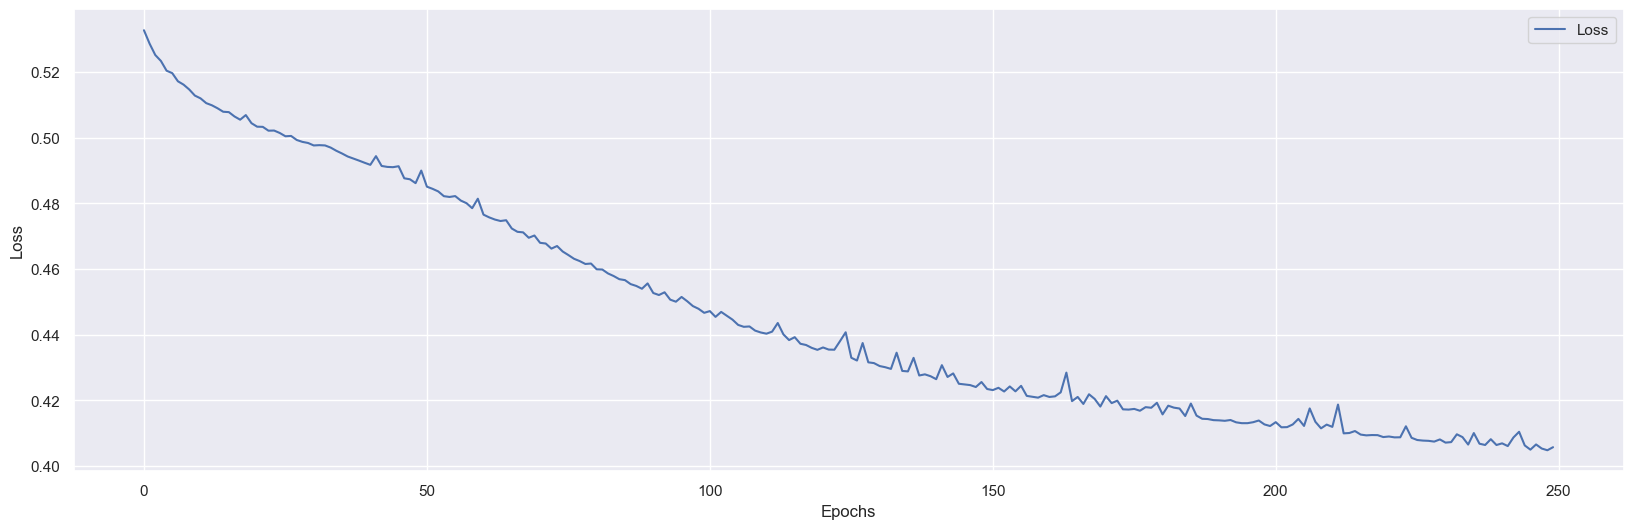

First epoch loss - 0.5326780038126401
Last epoch loss - 0.4057439114737952


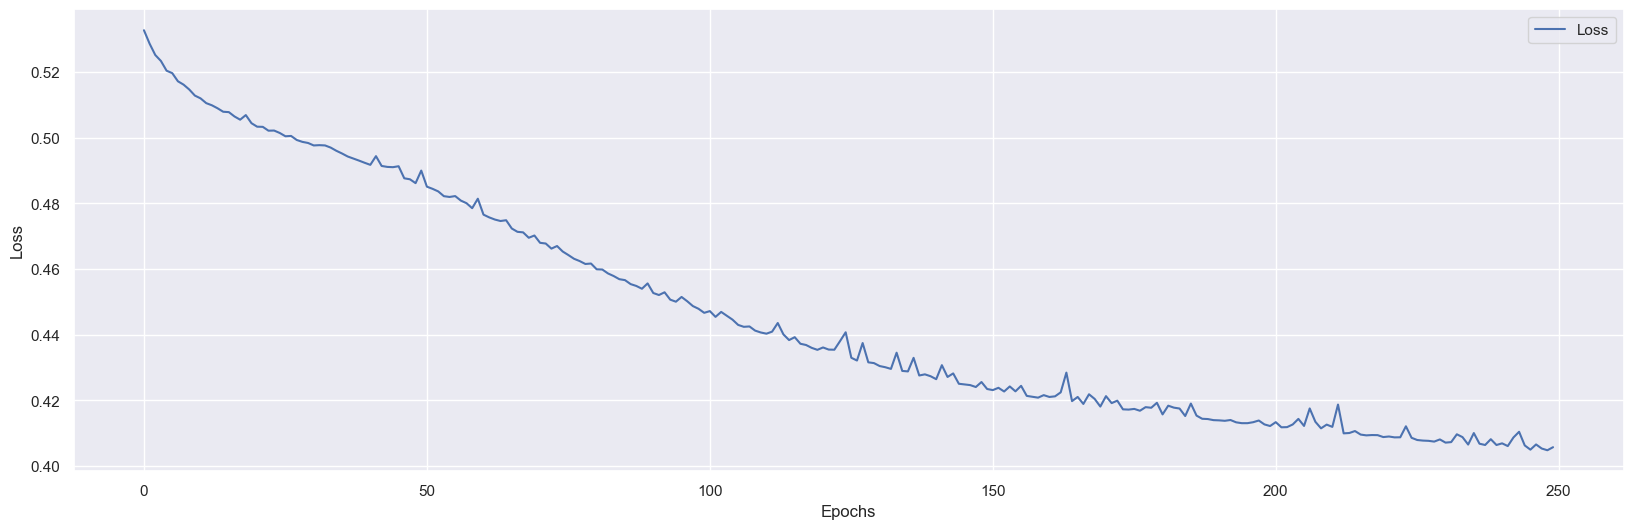

In [89]:
net_arch = (1, 25, 15, 5, 1)
mlp = MLP(net_arch)
epochs = 250
epoch_losses = mlp.train(X_train, y_train, epochs=epochs)
# plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

R^2 = 0.1977261328180232


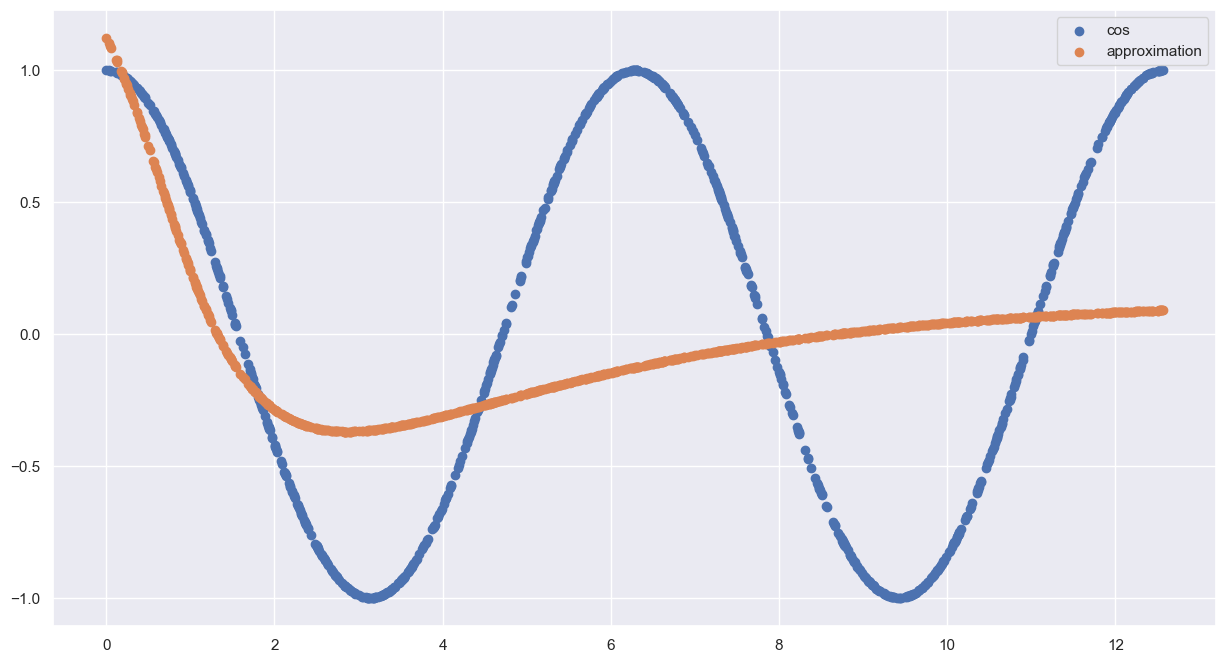

In [104]:
# Plot prediction results on test set
ypred_test = mlp.predict(X_test)

print(f"R^2 = {R_square(ypred_test, y_test)}")

fig, ax = plt.subplots()
ax.scatter(X_test, y_test, label='cos')
ax.scatter(X_test, ypred_test, label='approximation')
ax.legend()

In [91]:
df = pd.read_csv('2. Mushroom_dataset',delimiter=',',names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])
df.head()

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class-label               8416 non-null   object
 1   cap-shape                 8416 non-null   object
 2   cap-surface               8416 non-null   object
 3   cap-color                 8416 non-null   object
 4   bruises                   8416 non-null   object
 5   odor                      8416 non-null   object
 6   gill-attachment           8416 non-null   object
 7   gill-spacing              8416 non-null   object
 8   gill-size                 8416 non-null   object
 9   gill-color                8416 non-null   object
 10  stalk-shape               8416 non-null   object
 11  stalk-root                8416 non-null   object
 12  stalk-surface-above-ring  8416 non-null   object
 13  stalk-surface-below-ring  8416 non-null   object
 14  stalk-color-above-ring  

In [93]:
df.describe()

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,4864,3800,5316,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


In [94]:
df['class-label'].value_counts()

class-label
EDIBLE       4488
POISONOUS    3928
Name: count, dtype: int64

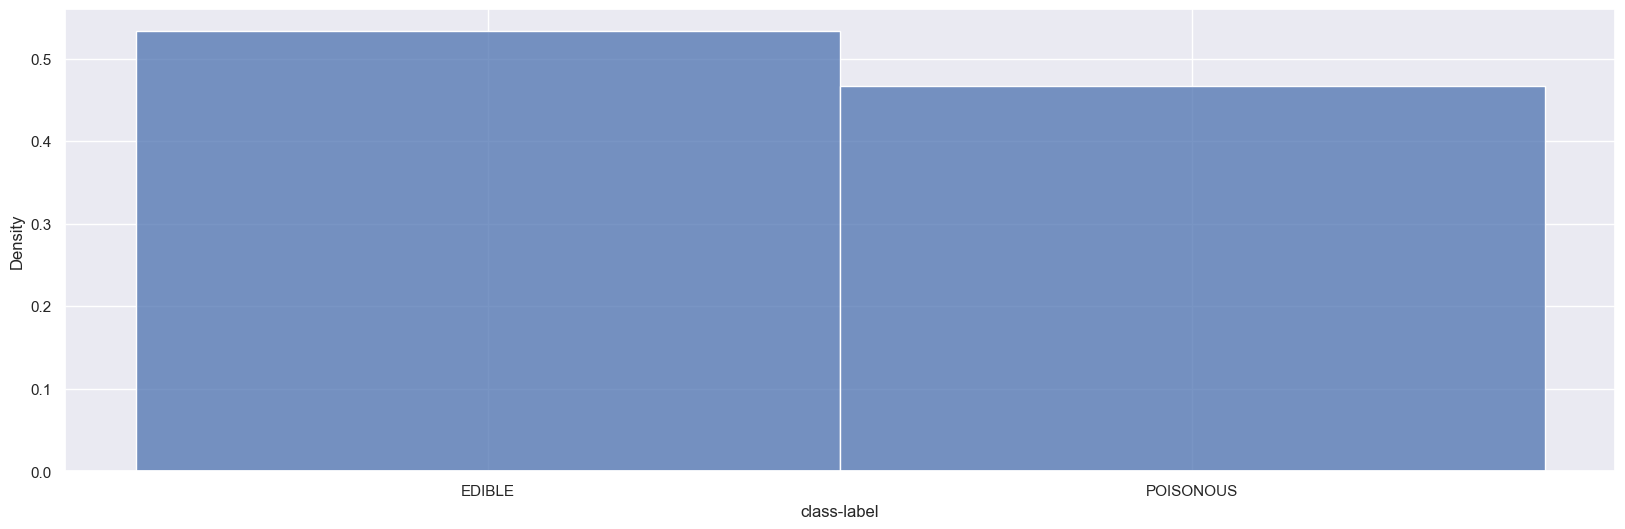

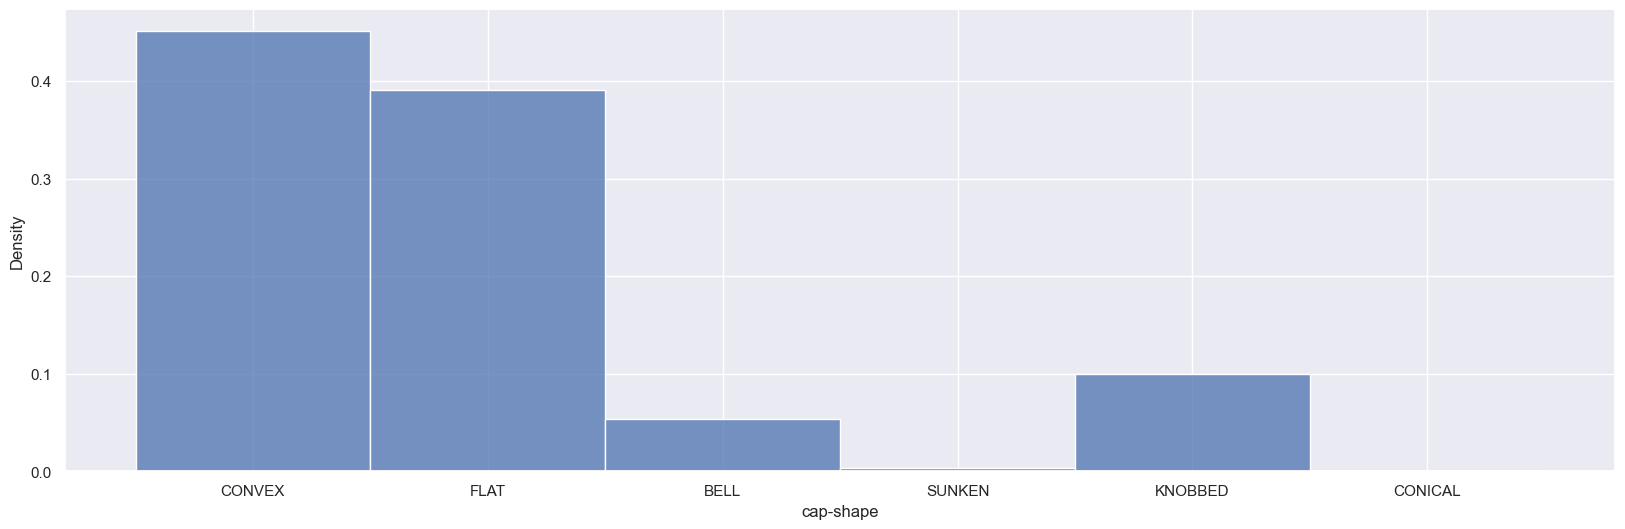

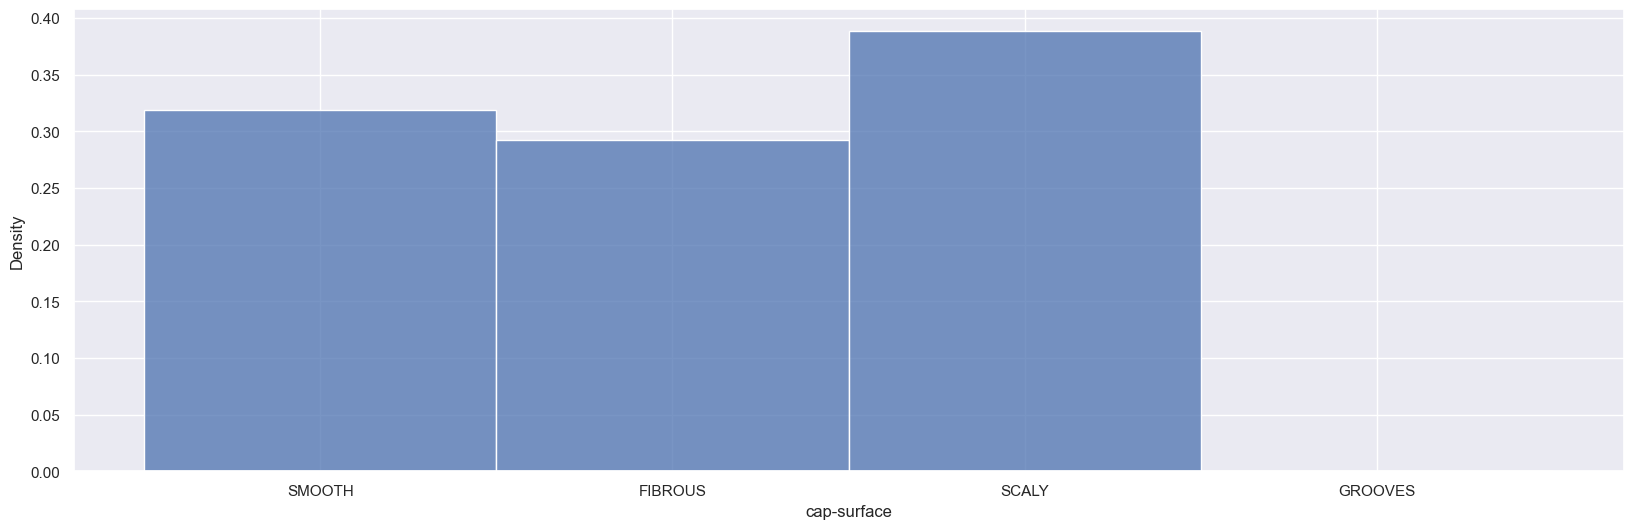

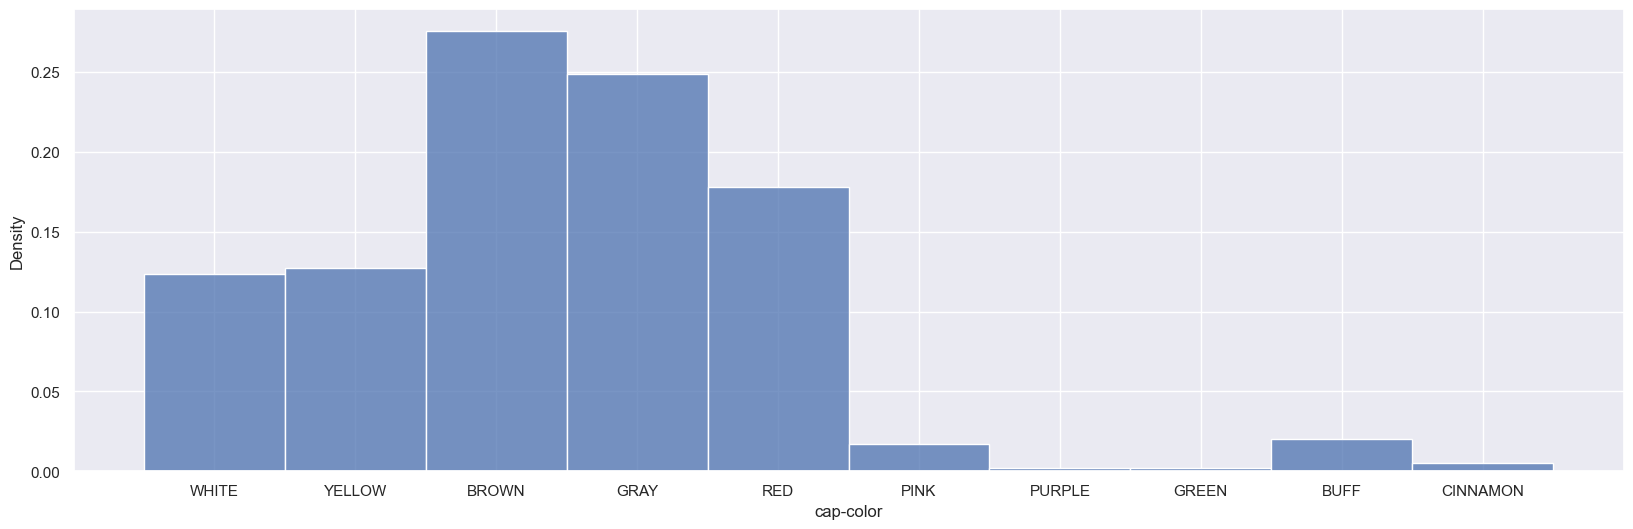

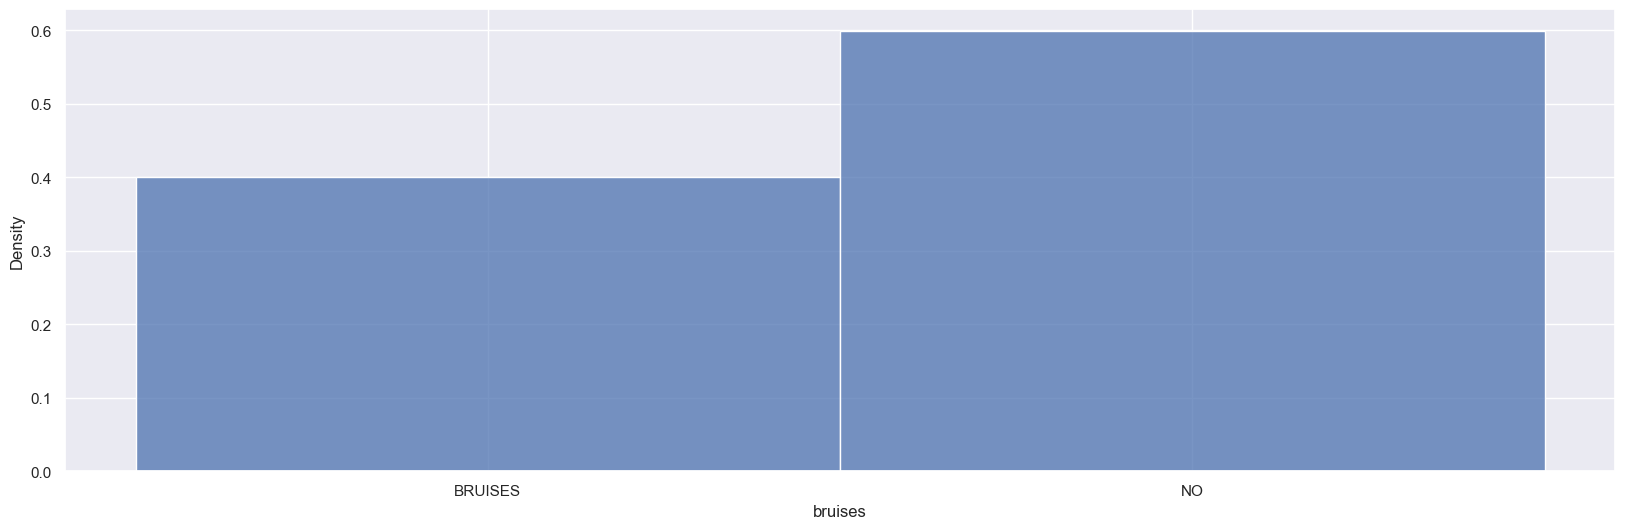

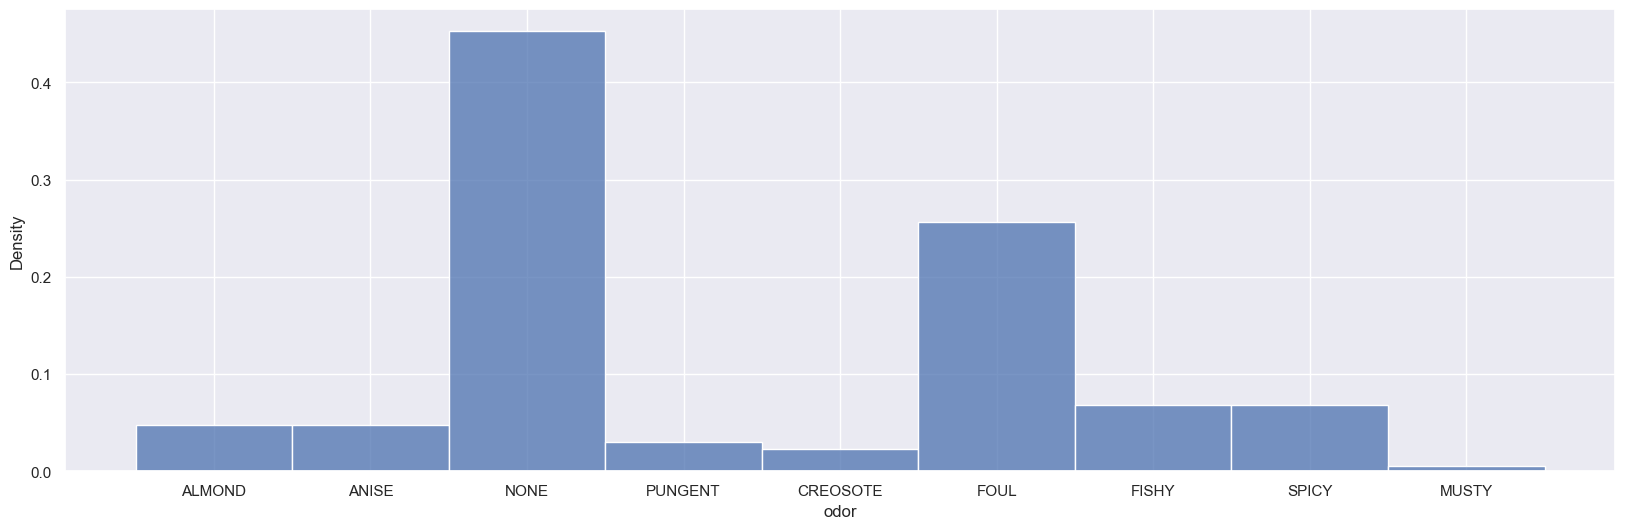

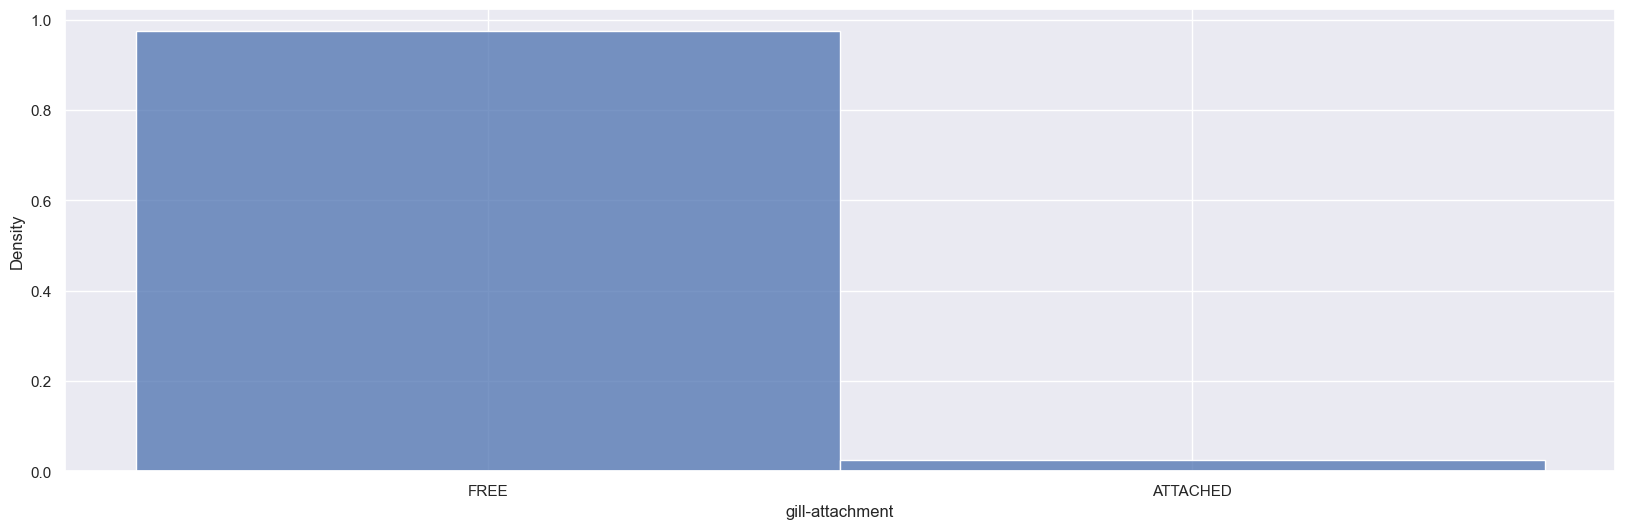

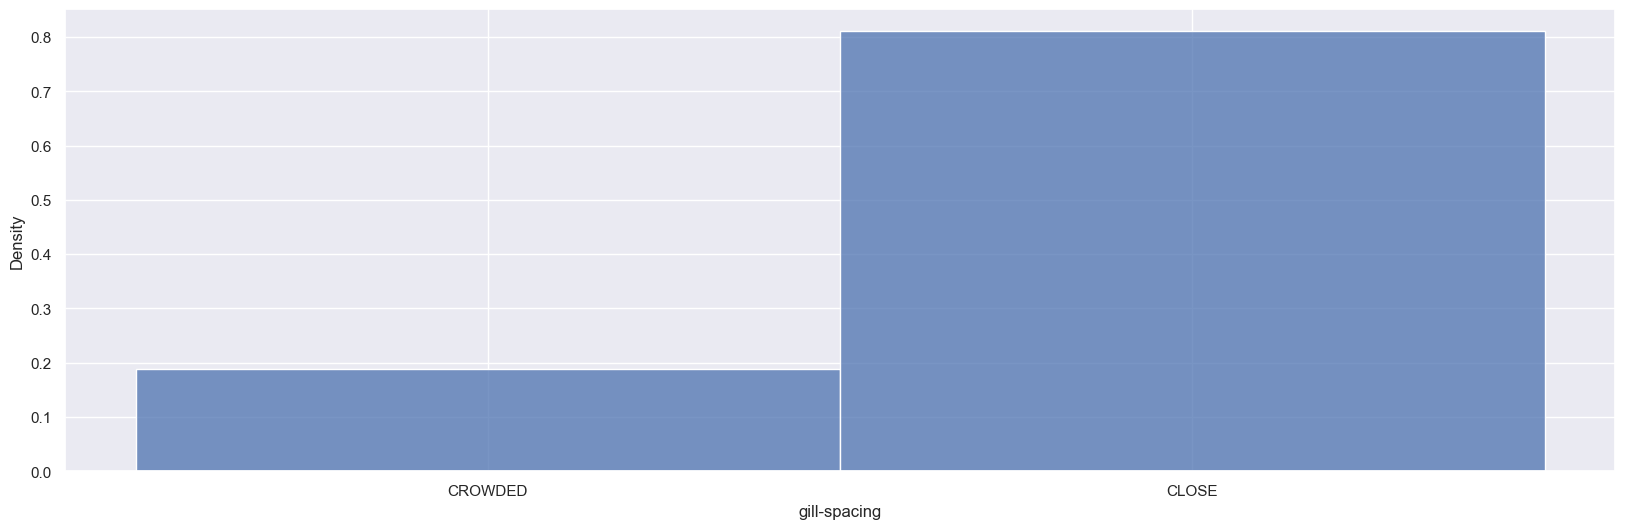

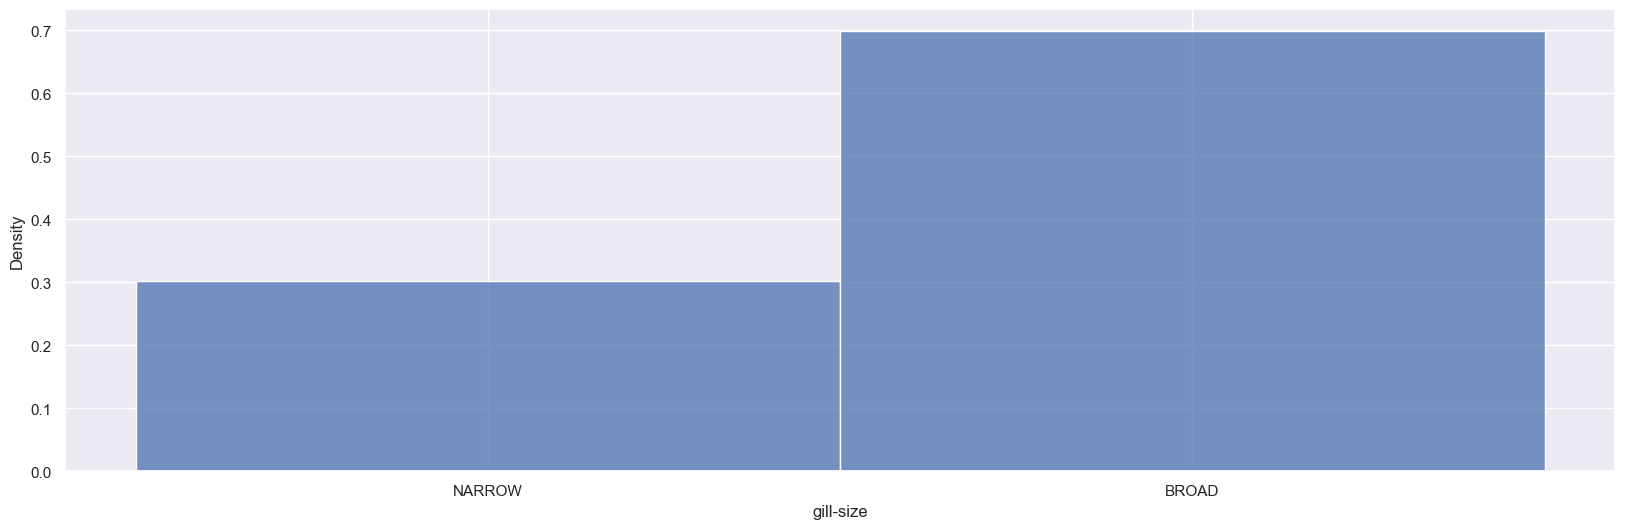

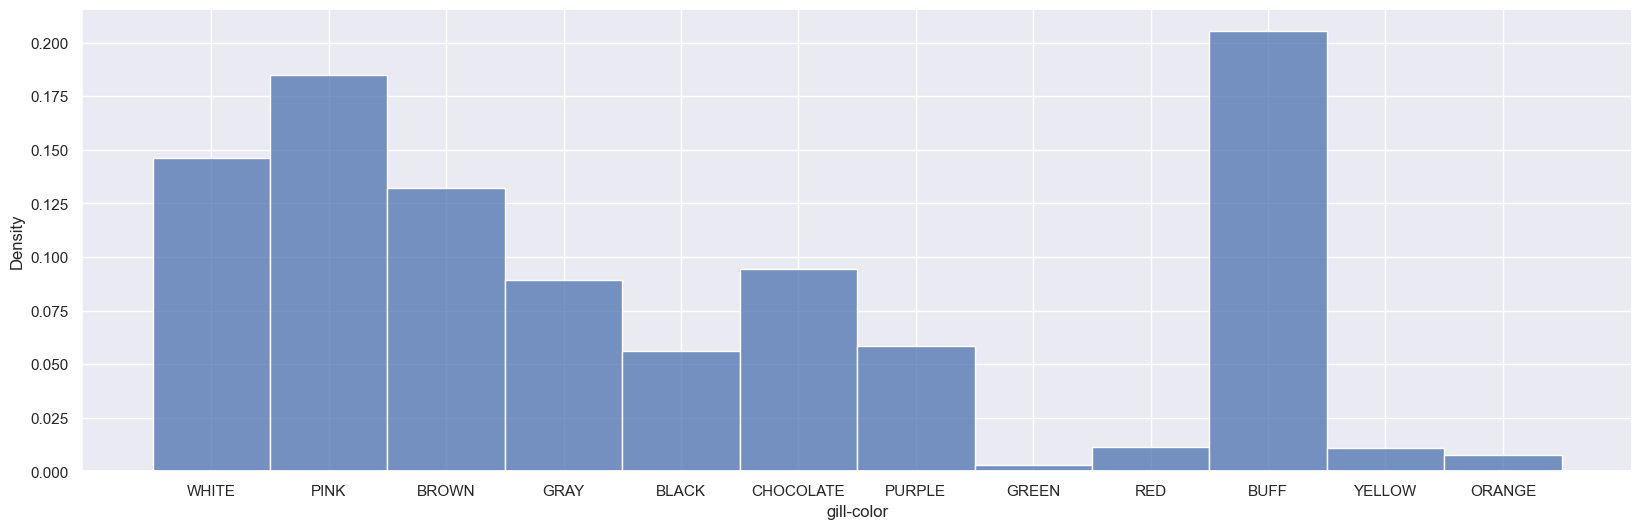

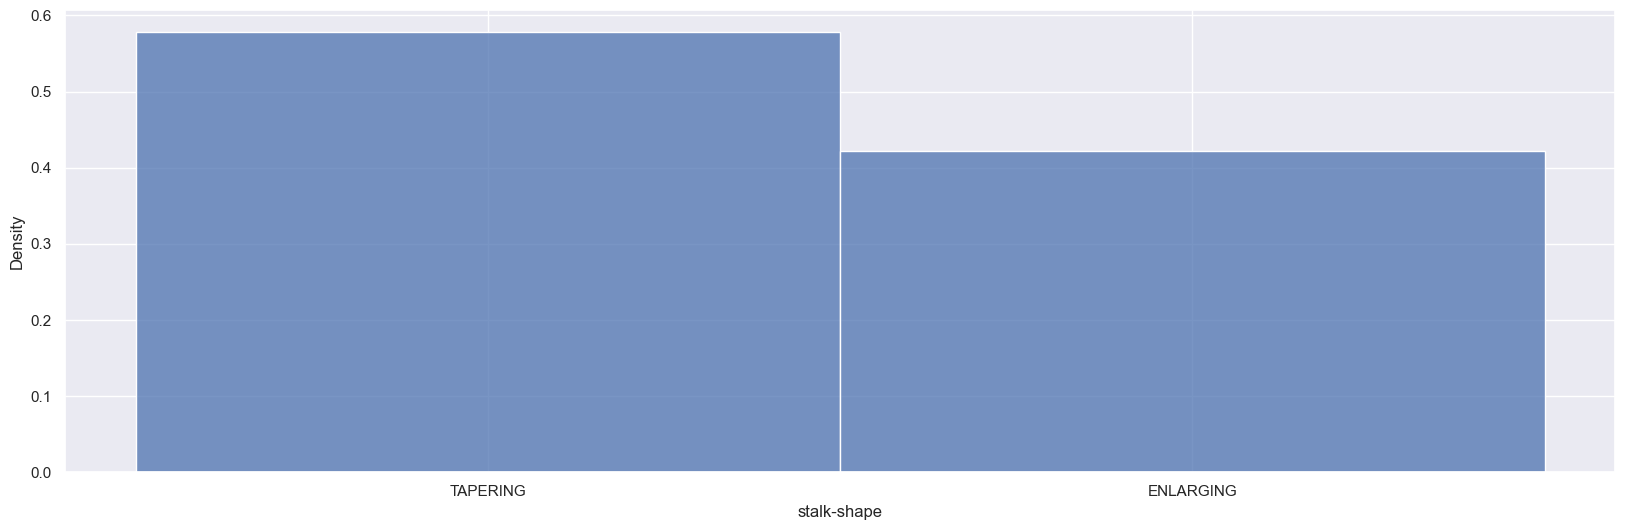

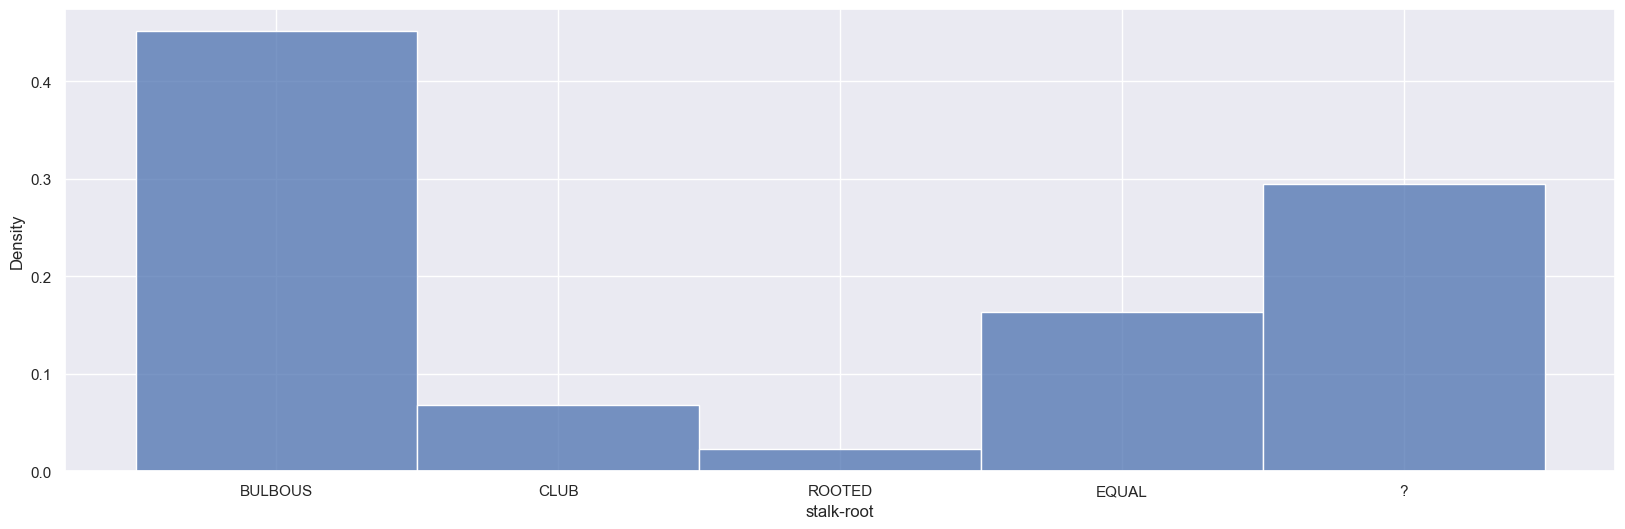

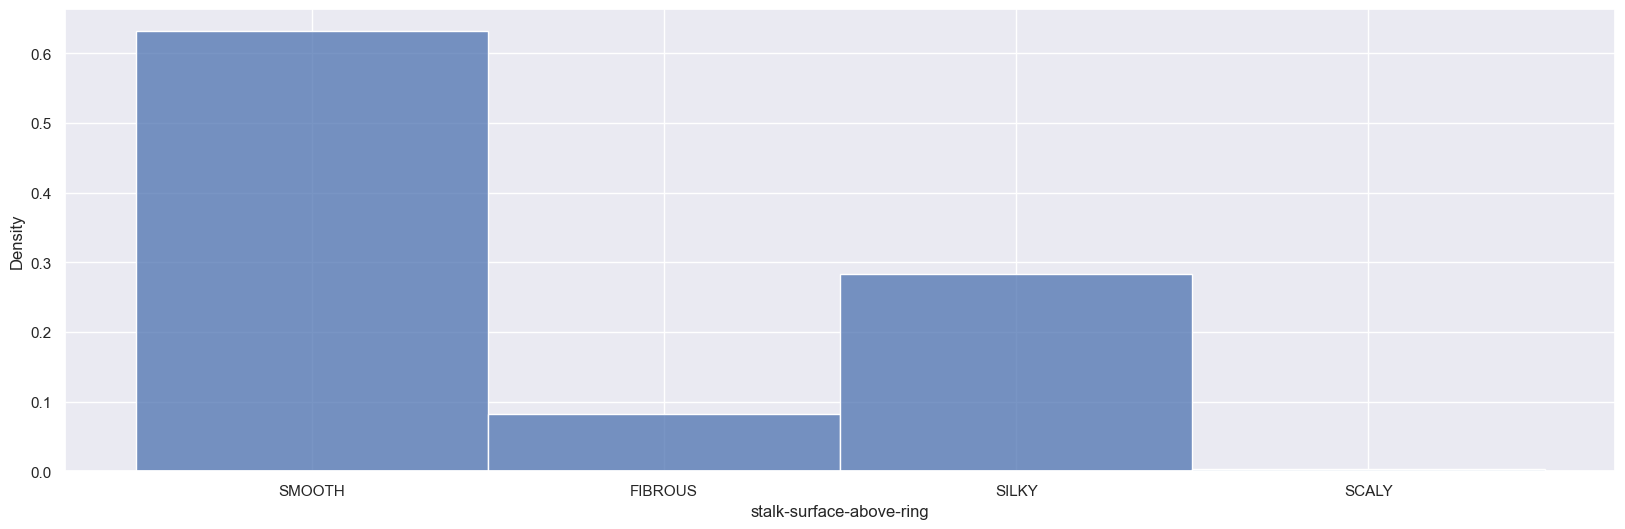

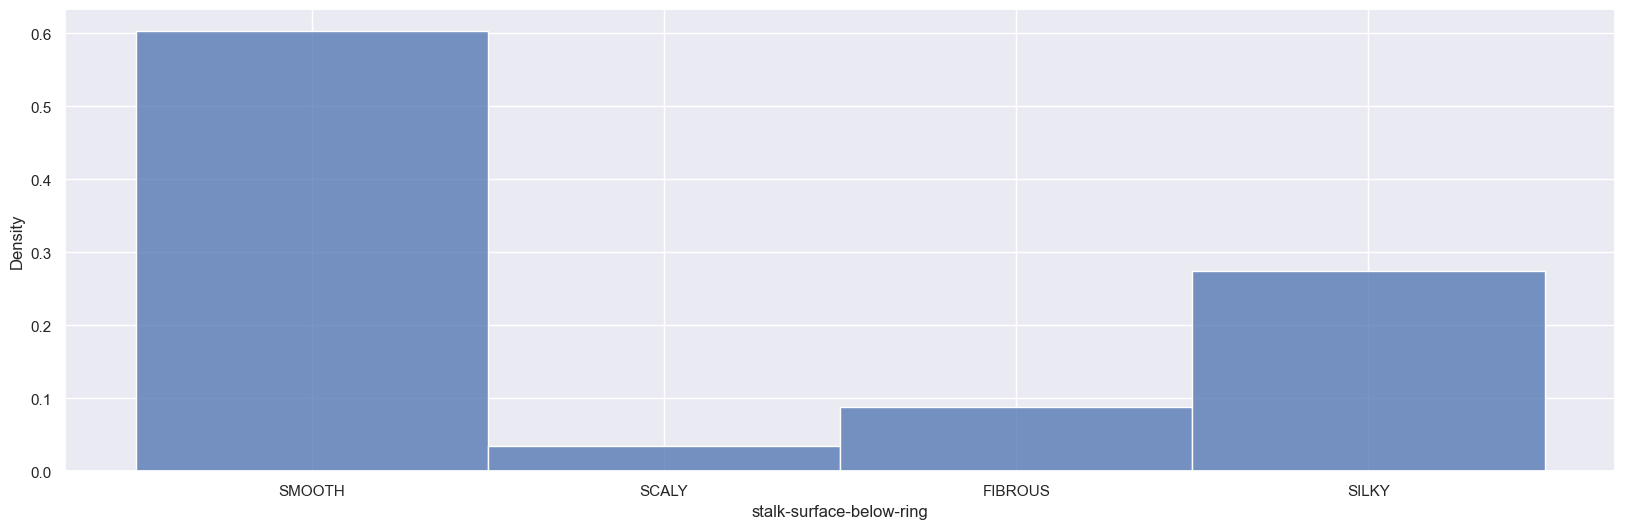

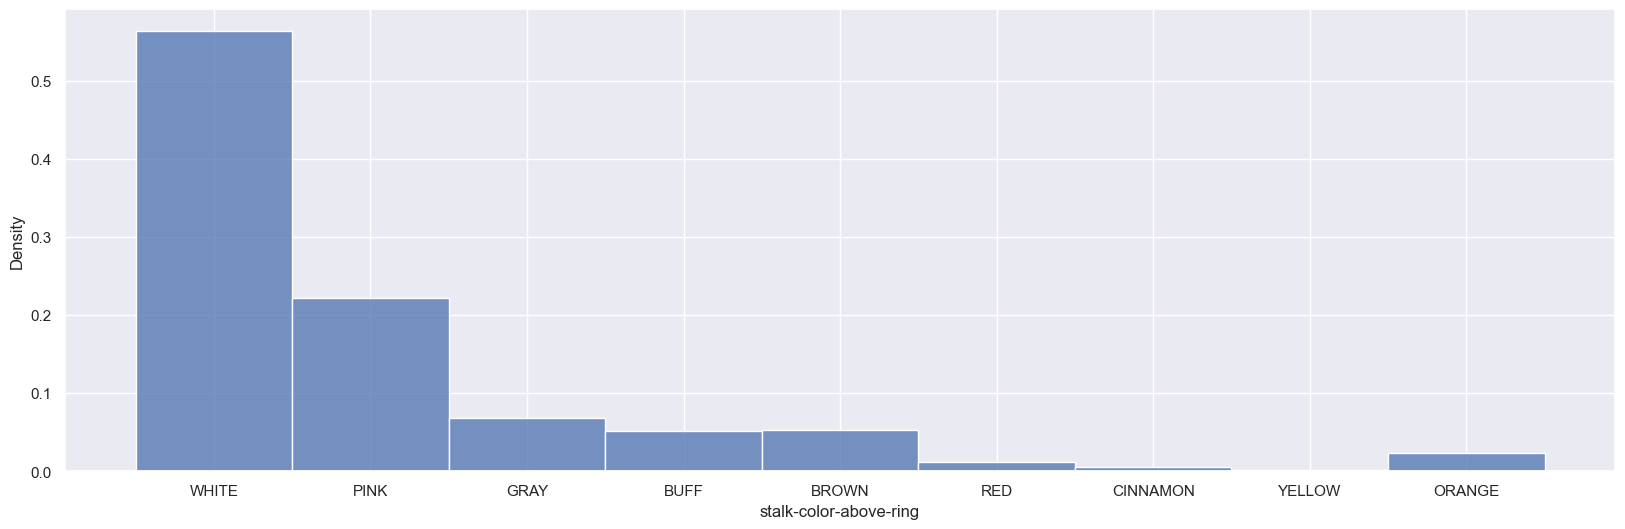

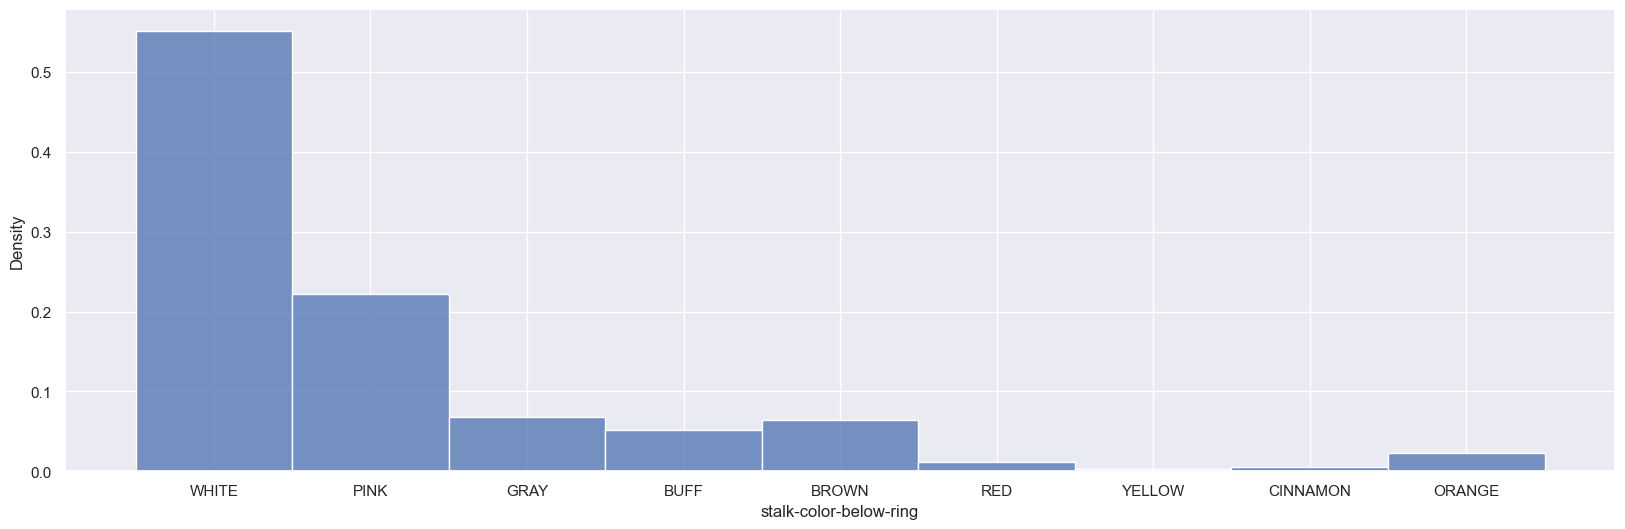

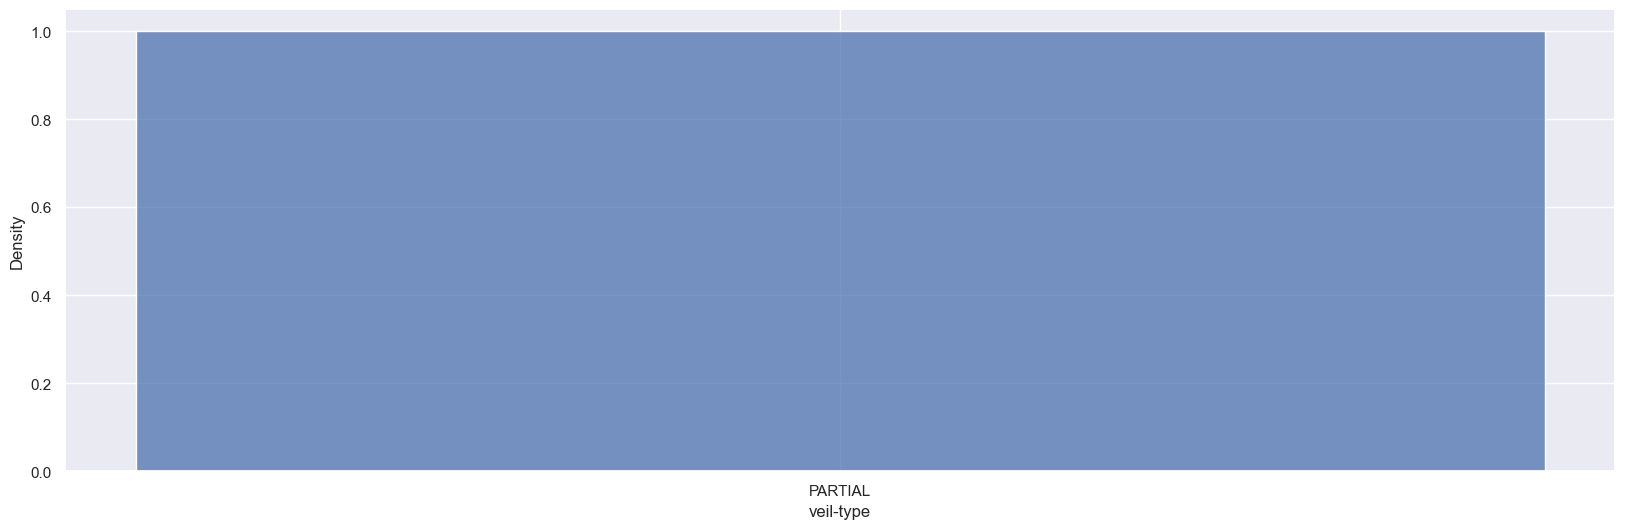

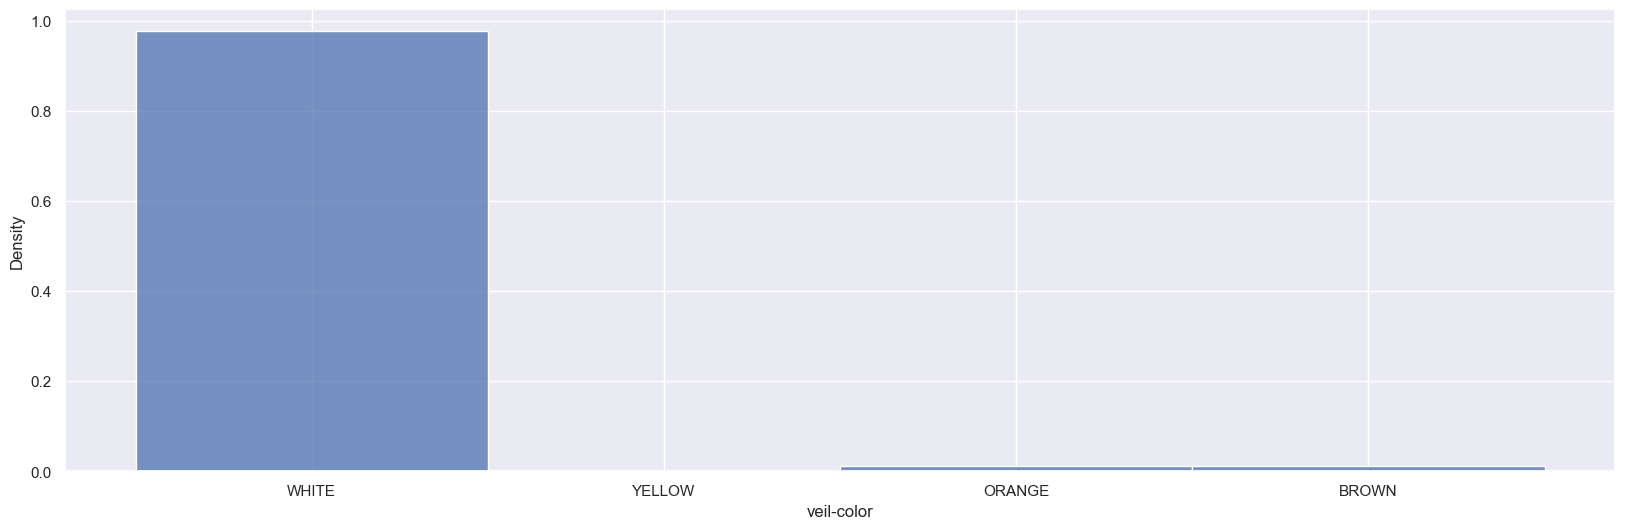

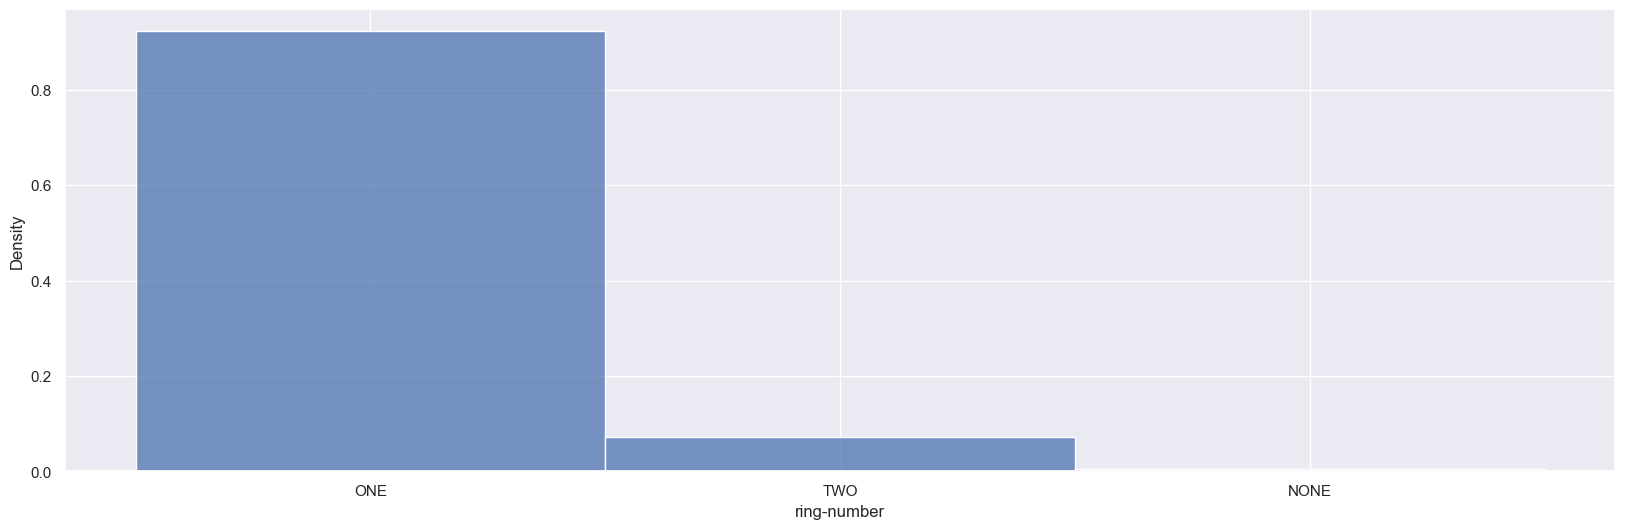

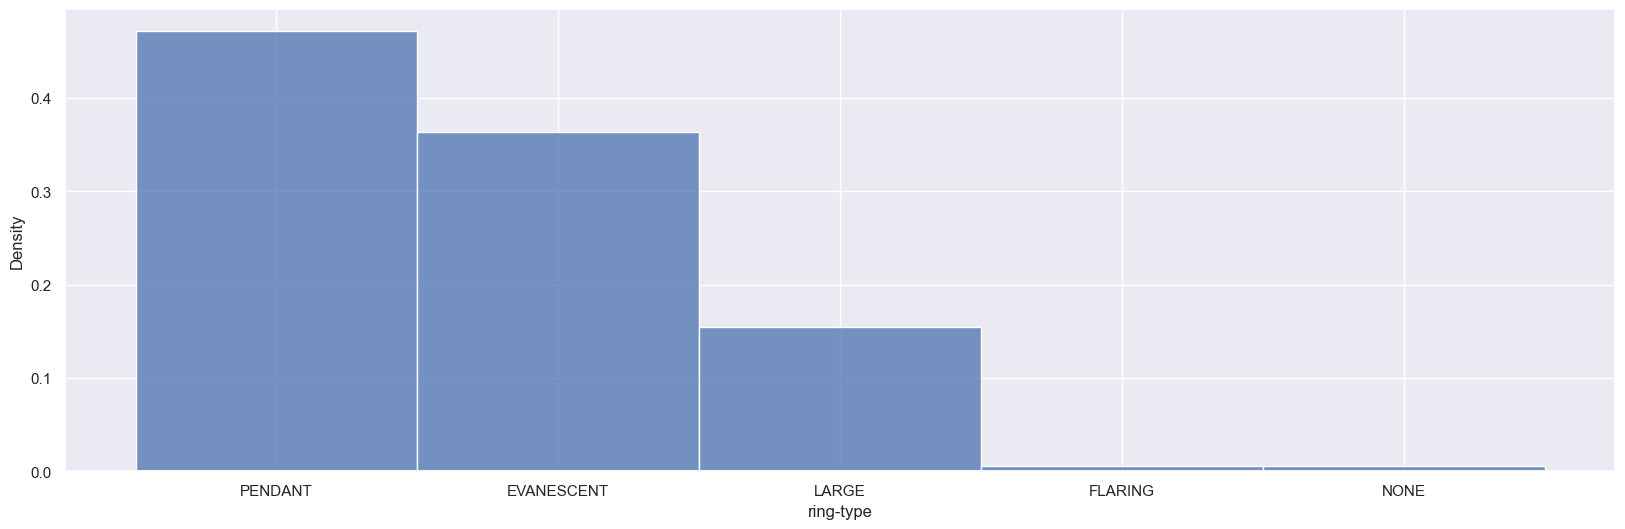

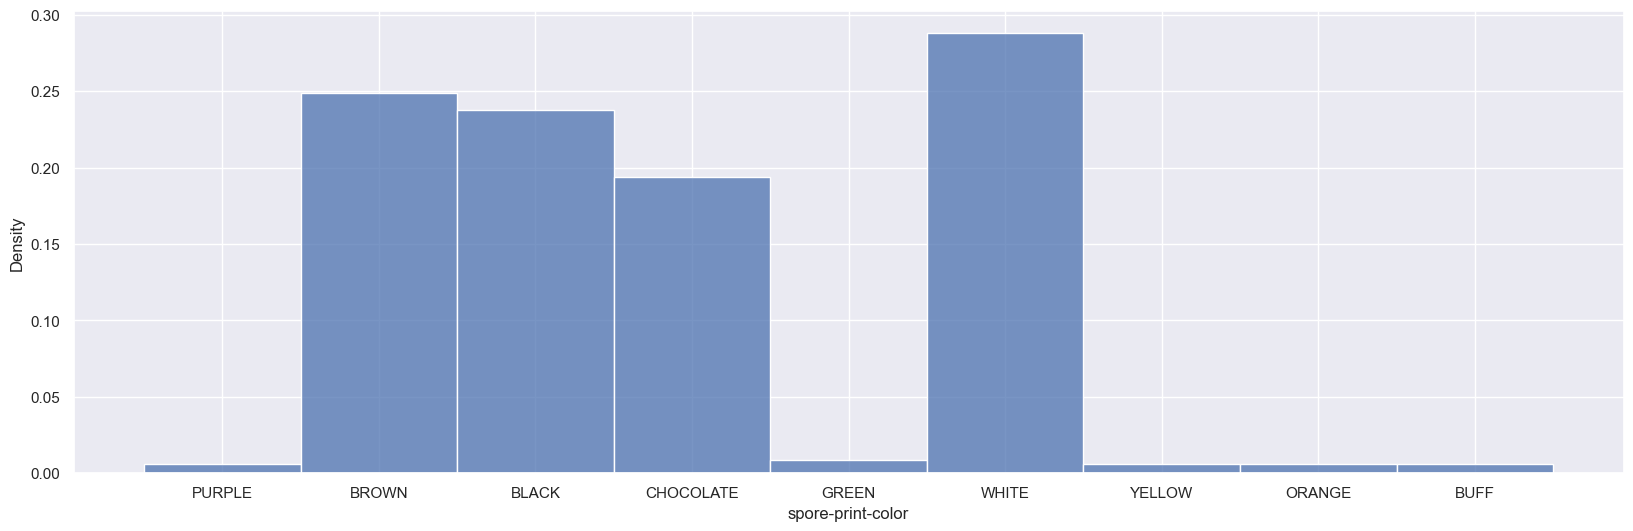

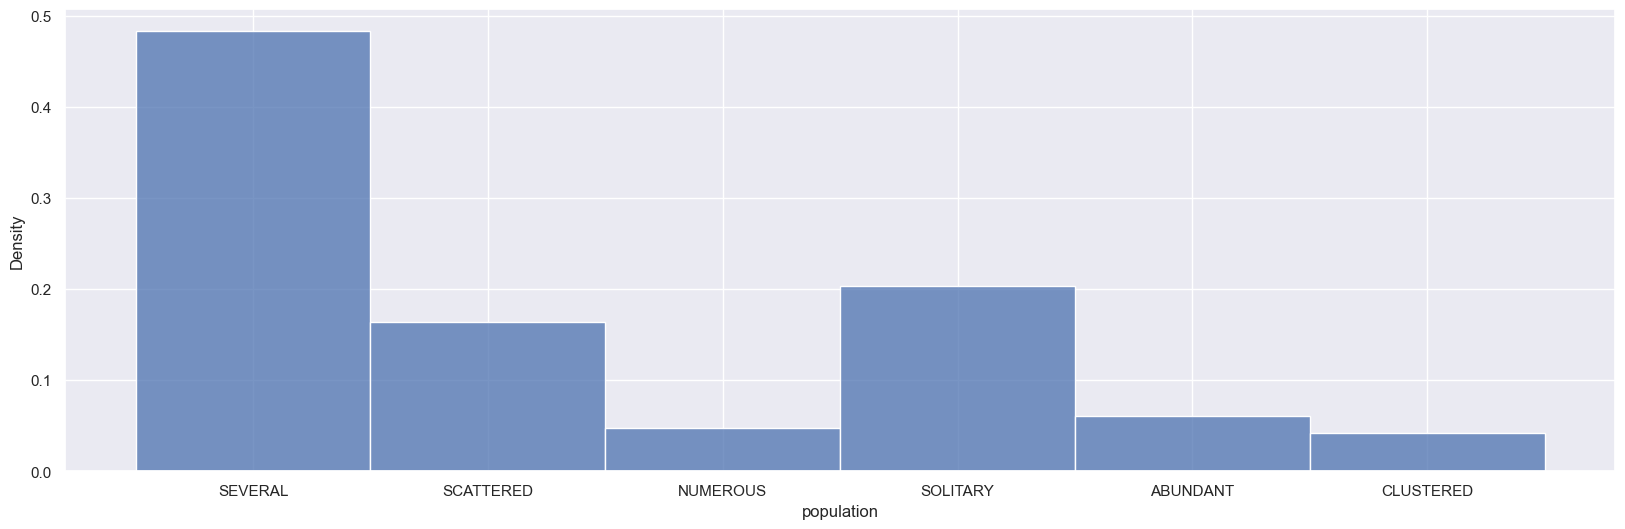

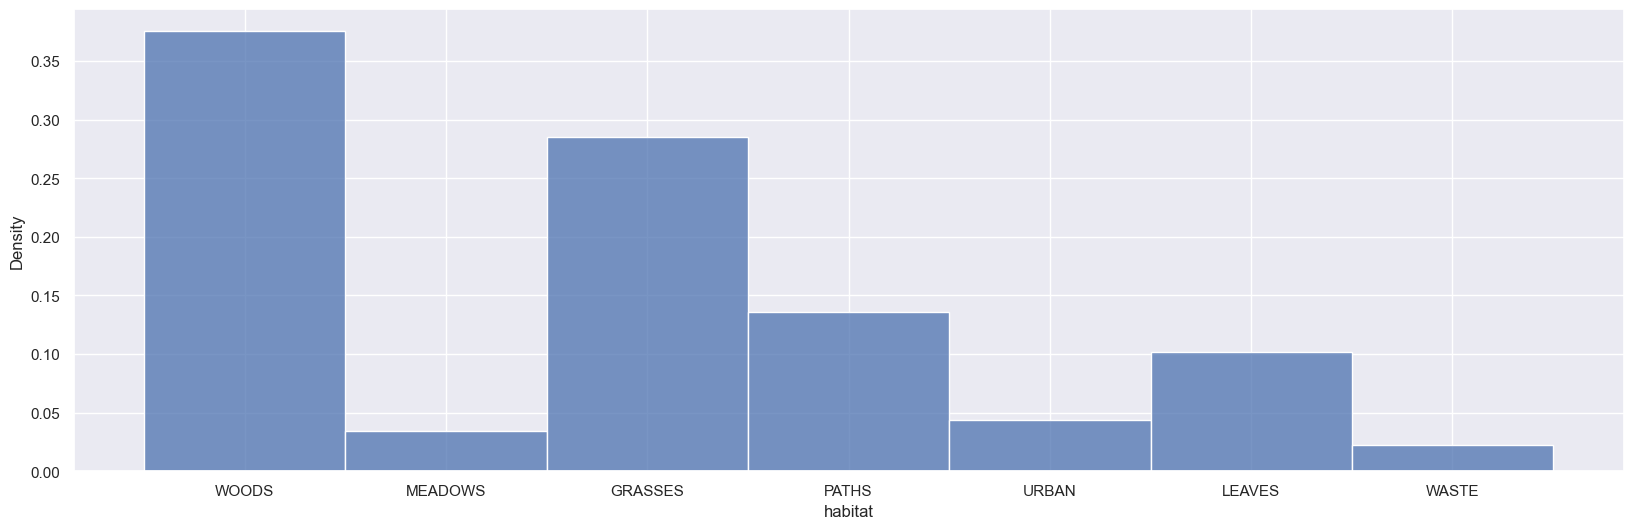

In [95]:
for i in df.columns:
    plt.figure(i)
    sns.histplot(df[i],stat="density")
    plt.show()

In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

df.head()

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,2,3,8,0,0,1,1,1,10,1,1,3,3,7,7,0,2,1,4,6,4,6
1,0,2,3,8,0,0,1,1,1,10,1,1,3,3,7,7,0,2,1,4,1,4,6
2,0,2,3,8,0,0,1,1,1,7,1,1,3,3,7,7,0,2,1,4,6,4,6
3,0,2,3,8,0,0,1,1,1,7,1,1,3,3,7,7,0,2,1,4,1,4,6
4,0,2,3,8,0,0,1,1,1,1,1,1,3,3,7,7,0,2,1,4,6,4,6


In [97]:
for col in df.columns:
    print(f'{col}: {str(df[col].nunique())}')

class-label: 2
cap-shape: 6
cap-surface: 4
cap-color: 10
bruises: 2
odor: 9
gill-attachment: 2
gill-spacing: 2
gill-size: 2
gill-color: 12
stalk-shape: 2
stalk-root: 5
stalk-surface-above-ring: 4
stalk-surface-below-ring: 4
stalk-color-above-ring: 9
stalk-color-below-ring: 9
veil-type: 1
veil-color: 4
ring-number: 3
ring-type: 5
spore-print-color: 9
population: 6
habitat: 7


In [98]:
def descriptive_stats(df):
    #adding additional statsical parameters to check our data
    C = len(df.columns)
    L = len(df.index)
    CN = df.count()
    NP = ((L-CN)/L)*100
    MN = df.min()
    Q1 = df.quantile(q=0.25)
    MA=df.mean() 
    ME=df.median() 
    Q3=df.quantile(q=0.75) 
    MX=df.max() 
    ST=df.std() 
    P=df.nunique() 
    IQ=Q3-Q1 

    frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
    frame=frame.T
    f=pd.DataFrame(frame)
    f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
    return f,f1

f,f1 = descriptive_stats(df)
f1

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
Количество,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Первый квартиль,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,5.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.000000,3.000000,0.000000
Среднее,0.466730,2.494297,1.733840,4.264734,0.598859,4.828897,0.974335,0.189163,0.301331,4.692490,0.577947,1.168251,2.464354,2.392110,5.493346,5.422053,0.000000,1.966730,1.065589,2.216730,3.000951,3.576046,3.120722
Медиана,0.000000,2.000000,2.000000,3.000000,1.000000,6.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,3.000000,3.000000,7.000000,7.000000,0.000000,2.000000,1.000000,2.000000,3.000000,4.000000,3.000000
Третий квартиль,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,1.000000,0.000000,1.000000,7.000000,1.000000,2.000000,3.000000,3.000000,7.000000,7.000000,0.000000,2.000000,1.000000,4.000000,7.000000,4.000000,6.000000
Максимум,1.000000,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,1.000000,4.000000,3.000000,3.000000,8.000000,8.000000,0.000000,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000
Стандартное отклонение,0.498922,0.892014,1.190765,3.403228,0.490159,1.961047,0.158144,0.391662,0.458863,3.353737,0.493916,1.092390,0.864793,0.914532,2.128817,2.196872,0.000000,0.238505,0.269635,1.817479,2.824054,1.314272,2.552022
Мощность,2.000000,6.000000,4.000000,10.000000,2.000000,9.000000,2.000000,2.000000,2.000000,12.000000,2.000000,5.000000,4.000000,4.000000,9.000000,9.000000,1.000000,4.000000,3.000000,5.000000,9.000000,6.000000,7.000000


In [99]:
df = df.drop(columns=['veil-type'])
df.head()

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,2,3,8,0,0,1,1,1,10,1,1,3,3,7,7,2,1,4,6,4,6
1,0,2,3,8,0,0,1,1,1,10,1,1,3,3,7,7,2,1,4,1,4,6
2,0,2,3,8,0,0,1,1,1,7,1,1,3,3,7,7,2,1,4,6,4,6
3,0,2,3,8,0,0,1,1,1,7,1,1,3,3,7,7,2,1,4,1,4,6
4,0,2,3,8,0,0,1,1,1,1,1,1,3,3,7,7,2,1,4,6,4,6


In [100]:
f, f1 = descriptive_stats(df)
f1

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
Количество,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Первый квартиль,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,5.000000,5.000000,2.000000,1.000000,0.000000,1.000000,3.000000,0.000000
Среднее,0.466730,2.494297,1.733840,4.264734,0.598859,4.828897,0.974335,0.189163,0.301331,4.692490,0.577947,1.168251,2.464354,2.392110,5.493346,5.422053,1.966730,1.065589,2.216730,3.000951,3.576046,3.120722
Медиана,0.000000,2.000000,2.000000,3.000000,1.000000,6.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,3.000000,3.000000,7.000000,7.000000,2.000000,1.000000,2.000000,3.000000,4.000000,3.000000
Третий квартиль,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,1.000000,0.000000,1.000000,7.000000,1.000000,2.000000,3.000000,3.000000,7.000000,7.000000,2.000000,1.000000,4.000000,7.000000,4.000000,6.000000
Максимум,1.000000,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,1.000000,4.000000,3.000000,3.000000,8.000000,8.000000,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000
Стандартное отклонение,0.498922,0.892014,1.190765,3.403228,0.490159,1.961047,0.158144,0.391662,0.458863,3.353737,0.493916,1.092390,0.864793,0.914532,2.128817,2.196872,0.238505,0.269635,1.817479,2.824054,1.314272,2.552022
Мощность,2.000000,6.000000,4.000000,10.000000,2.000000,9.000000,2.000000,2.000000,2.000000,12.000000,2.000000,5.000000,4.000000,4.000000,9.000000,9.000000,4.000000,3.000000,5.000000,9.000000,6.000000,7.000000


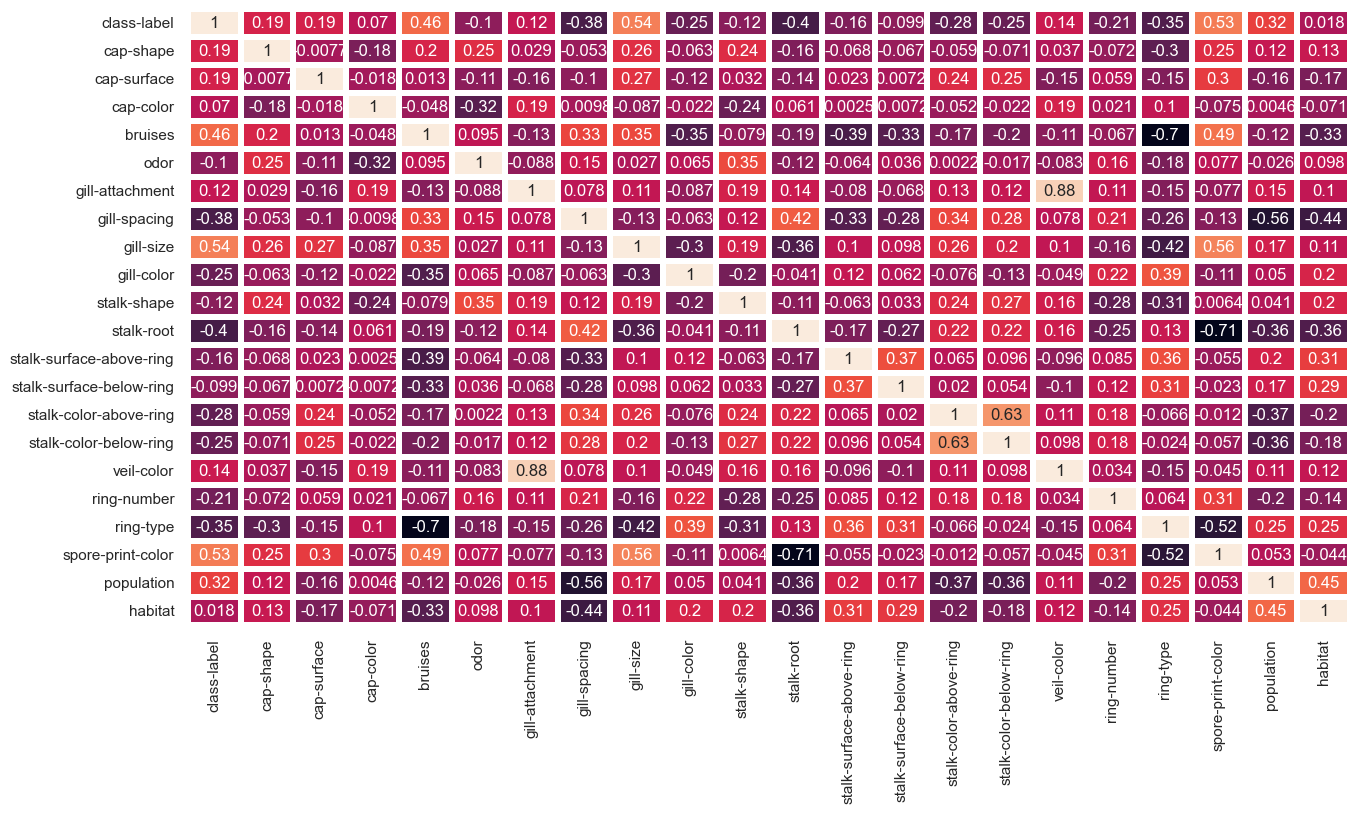

In [101]:
def make_heat_map(df):
    sns.set(rc={'figure.figsize': (15,8),})
    sns.heatmap(df.corr(), annot=True, linewidths=3, cbar=False)

make_heat_map(df)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   class-label               8416 non-null   int32
 1   cap-shape                 8416 non-null   int32
 2   cap-surface               8416 non-null   int32
 3   cap-color                 8416 non-null   int32
 4   bruises                   8416 non-null   int32
 5   odor                      8416 non-null   int32
 6   gill-attachment           8416 non-null   int32
 7   gill-spacing              8416 non-null   int32
 8   gill-size                 8416 non-null   int32
 9   gill-color                8416 non-null   int32
 10  stalk-shape               8416 non-null   int32
 11  stalk-root                8416 non-null   int32
 12  stalk-surface-above-ring  8416 non-null   int32
 13  stalk-surface-below-ring  8416 non-null   int32
 14  stalk-color-above-ring    8416 non-null 

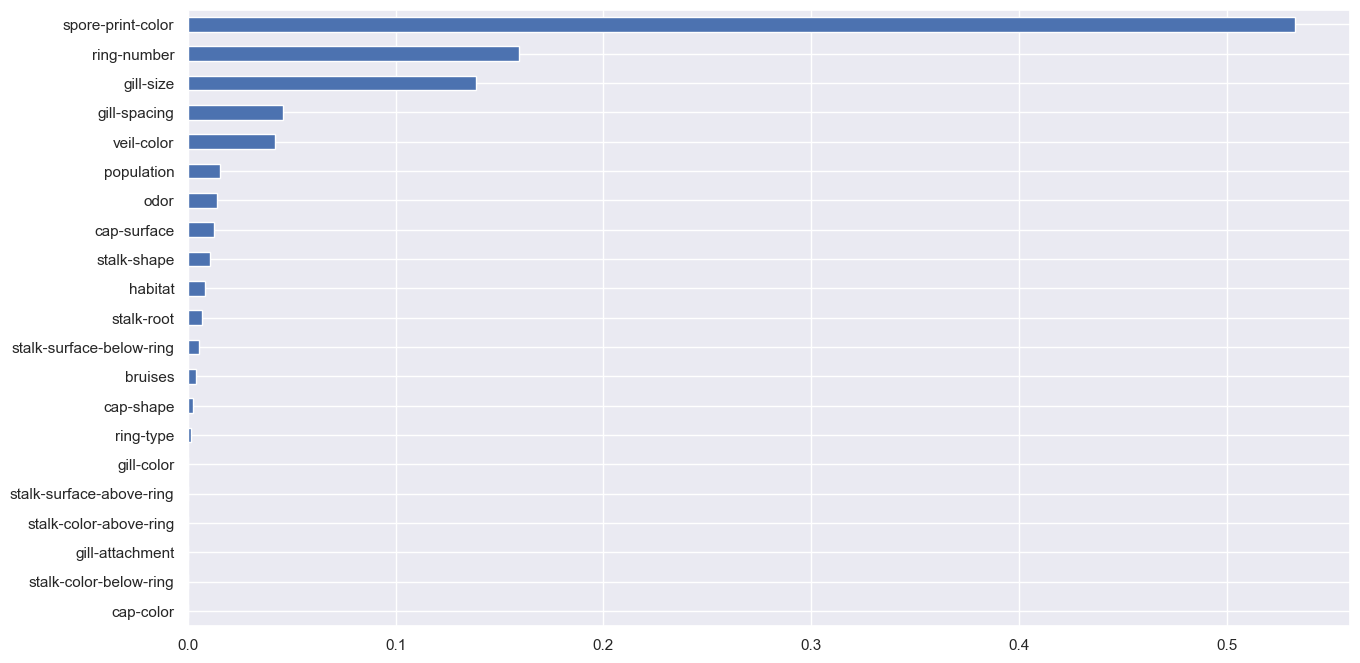

In [103]:
from sklearn.ensemble import RandomForestRegressor
def feature_importance(X, Y):

    regr = RandomForestRegressor(max_depth=20, random_state=42)
    regr.fit(X, Y)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns).sort_values(ascending=True)
    feat_importances.plot(kind='barh')

X=df.drop('class-label',axis=1)
Y=df['class-label']

feature_importance(X, Y)

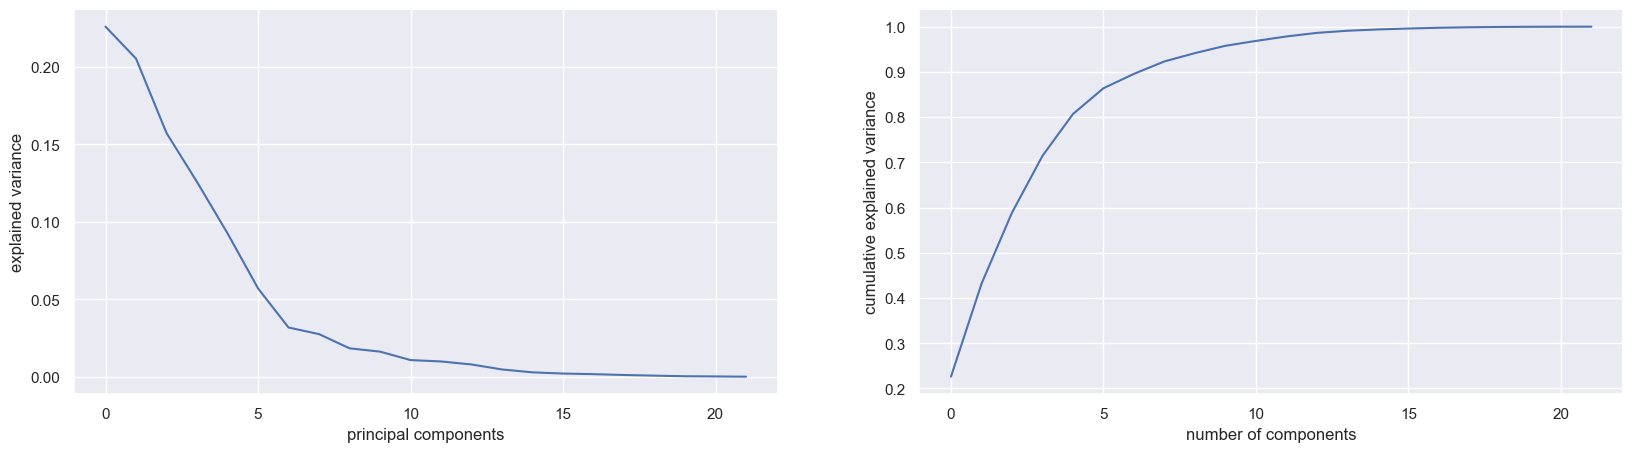

In [119]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=123) #instant
pca.fit(df)
fig = plt.figure(figsize = (20,5))
ax = plt.subplot(121)
plt.plot(pca.explained_variance_ratio_) 
plt.xlabel('principal components')
plt.ylabel('explained variance')
ax2 = plt.subplot (122)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [121]:
X = df.drop('class-label', axis = 1)
y = df['class-label']

X_train,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=42)
print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')
print(f'The size of the target variable for training sample: {y_train.shape}')
print(f'The size of the target variable for test sample: {y_test.shape}')

Size of training set: (5891, 21)
Size of test set: (2525, 21)
The size of the target variable for training sample: (5891,)
The size of the target variable for test sample: (2525,)


In [105]:
def confusion_matrix(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FP = np.sum((y == 0) & (y_pred == 1))
    FN = np.sum((y == 1) & (y_pred == 0))
    return TP,TN,FP,FN

def accuracy(TP,TN,FP,FN):
    return (TP + TN)/(TP + TN + FP + FN)

def percision(TP,FP):
    return TP/(TP + FP) if (TP + FP) != 0 else 0

def recall(TP, FN):
    return TP/ (TP + FN) if (TP + FN) != 0 else 0

def f1_score(percision, recall):
    return 2 * (percision * recall) / (percision + recall) if percision + recall != 0 else 0

def roc_curve_manual(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)
    tpr_list = []
    fpr_list = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
        tpr = recall(TP, FN)
        fpr = FP / (FP + TN) if FP + TN != 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds

def auc_manual(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

In [ ]:
net_arch = (22, 25, 15, 5, 1)
mlp = MLP(net_arch)
epochs = 250
epoch_losses = mlp.train(X_train, y_train, epochs=epochs)
# plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")